In [1]:
#imports
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


### Download Data

In [2]:
#retrieve image zip folder
!curl -L -o pix.zip https://www.dropbox.com/s/b0xxuq5pi91ckv5/pix.zip?dl=0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
100  1034    0  1034    0     0    129      0 --:--:--  0:00:08 --:--:--   795
100 3066M  100 3066M    0     0  12.5M      0  0:04:05  0:04:05 --:--:-- 12.2M 0:01:53  0:02:24 12.3M 0:02:24  0:01:47 13.2M


In [ ]:
#unzip images and store in data folder
!mkdir data
!unzip -q pix.zip -d data

In [12]:
#Remove all non 'rainview' images, verify
!rm data/pix/*.gif
!rm data/pix/*.csv
!rm data/pix/radar*
!rm data/pix/sat*
!ls data/pix

rainview_#U00c5rhus_124594_1911222200.png
rainview_#U00c5rhus_124594_1911222300.png
rainview_#U00c5rhus_124594_1911230000.png
rainview_#U00c5rhus_124594_1911230100.png
rainview_#U00c5rhus_124594_1911230200.png
rainview_#U00c5rhus_124594_1911230300.png
rainview_#U00c5rhus_124594_1911230400.png
rainview_#U00c5rhus_124594_1911230500.png
rainview_#U00c5rhus_124594_1911230600.png
rainview_#U00c5rhus_124594_1911230700.png
rainview_#U00c5rhus_124594_1911230800.png
rainview_#U00c5rhus_124594_1911230900.png
rainview_#U00c5rhus_124594_1911231000.png
rainview_#U00c5rhus_124594_1911231100.png
rainview_#U00c5rhus_124594_1911231200.png
rainview_#U00c5rhus_124594_1911231300.png
rainview_#U00c5rhus_124594_1911231400.png
rainview_#U00c5rhus_124594_1911231500.png
rainview_#U00c5rhus_124594_1911231600.png
rainview_#U00c5rhus_124594_1911231700.png
rainview_#U00c5rhus_124594_1911231800.png
rainview_#U00c5rhus_124594_1911231900.png
rainview_#U00c5rhus_124594_1911232000.png
rainview_#U00c5rhus_124594_1911232

rainview_Brno_3403192_1911222200.png
rainview_Brno_3403192_1911222300.png
rainview_Brno_3403192_1911230000.png
rainview_Brno_3403192_1911230100.png
rainview_Brno_3403192_1911230200.png
rainview_Brno_3403192_1911230300.png
rainview_Brno_3403192_1911230400.png
rainview_Brno_3403192_1911230500.png
rainview_Brno_3403192_1911230600.png
rainview_Brno_3403192_1911230700.png
rainview_Brno_3403192_1911230800.png
rainview_Brno_3403192_1911230900.png
rainview_Brno_3403192_1911231000.png
rainview_Brno_3403192_1911231100.png
rainview_Brno_3403192_1911231200.png
rainview_Brno_3403192_1911231300.png
rainview_Brno_3403192_1911231400.png
rainview_Brno_3403192_1911231500.png
rainview_Brno_3403192_1911231600.png
rainview_Brno_3403192_1911231700.png
rainview_Brno_3403192_1911231800.png
rainview_Brno_3403192_1911231900.png
rainview_Brno_3403192_1911232000.png
rainview_Brno_3403192_1911232100.png
rainview_Brno_3403192_1911232200.png
rainview_Brno_3403192_1911232300.png
rainview_Brno_3403192_1911240000.png
r

rainview_Fullerton_327159_1911300800.png
rainview_Fullerton_327159_1911300900.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911222200.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911222300.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230000.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230100.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230200.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230300.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230400.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230500.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230600.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230700.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230800.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911230900.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911231000.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911231100.png
rainview_G#U00f6teborg (Gothenburg)_311100_1911231200.png
rainview_G#U00f6teborg (Gothenburg)_311100_19112

rainview_Marseille_2606093_1911230300.png
rainview_Marseille_2606093_1911230400.png
rainview_Marseille_2606093_1911230500.png
rainview_Marseille_2606093_1911230600.png
rainview_Marseille_2606093_1911230700.png
rainview_Marseille_2606093_1911230800.png
rainview_Marseille_2606093_1911230900.png
rainview_Marseille_2606093_1911231000.png
rainview_Marseille_2606093_1911231100.png
rainview_Marseille_2606093_1911231200.png
rainview_Marseille_2606093_1911231300.png
rainview_Marseille_2606093_1911231400.png
rainview_Marseille_2606093_1911231500.png
rainview_Marseille_2606093_1911231600.png
rainview_Marseille_2606093_1911231700.png
rainview_Marseille_2606093_1911231800.png
rainview_Marseille_2606093_1911231900.png
rainview_Marseille_2606093_1911232000.png
rainview_Marseille_2606093_1911232100.png
rainview_Marseille_2606093_1911232200.png
rainview_Marseille_2606093_1911232300.png
rainview_Marseille_2606093_1911240000.png
rainview_Marseille_2606093_1911240100.png
rainview_Marseille_2606093_1911240

rainview_Sacramento_347627_1911251200.png
rainview_Sacramento_347627_1911251300.png
rainview_Sacramento_347627_1911251400.png
rainview_Sacramento_347627_1911251500.png
rainview_Sacramento_347627_1911251600.png
rainview_Sacramento_347627_1911251700.png
rainview_Sacramento_347627_1911251800.png
rainview_Sacramento_347627_1911251900.png
rainview_Sacramento_347627_1911252000.png
rainview_Sacramento_347627_1911252100.png
rainview_Sacramento_347627_1911252200.png
rainview_Sacramento_347627_1911252300.png
rainview_Sacramento_347627_1911260000.png
rainview_Sacramento_347627_1911260100.png
rainview_Sacramento_347627_1911260200.png
rainview_Sacramento_347627_1911260300.png
rainview_Sacramento_347627_1911260400.png
rainview_Sacramento_347627_1911260500.png
rainview_Sacramento_347627_1911260600.png
rainview_Sacramento_347627_1911260700.png
rainview_Sacramento_347627_1911260800.png
rainview_Sacramento_347627_1911260900.png
rainview_Sacramento_347627_1911261000.png
rainview_Sacramento_347627_1911261

rainview_Wichita_348426_1911272200.png
rainview_Wichita_348426_1911272300.png
rainview_Wichita_348426_1911280000.png
rainview_Wichita_348426_1911280100.png
rainview_Wichita_348426_1911280200.png
rainview_Wichita_348426_1911280300.png
rainview_Wichita_348426_1911280400.png
rainview_Wichita_348426_1911280500.png
rainview_Wichita_348426_1911280600.png
rainview_Wichita_348426_1911280700.png
rainview_Wichita_348426_1911280800.png
rainview_Wichita_348426_1911280900.png
rainview_Wichita_348426_1911281000.png
rainview_Wichita_348426_1911281100.png
rainview_Wichita_348426_1911281200.png
rainview_Wichita_348426_1911281300.png
rainview_Wichita_348426_1911281400.png
rainview_Wichita_348426_1911281500.png
rainview_Wichita_348426_1911281600.png
rainview_Wichita_348426_1911281700.png
rainview_Wichita_348426_1911281800.png
rainview_Wichita_348426_1911281900.png
rainview_Wichita_348426_1911282000.png
rainview_Wichita_348426_1911282100.png
rainview_Wichita_348426_1911282200.png
rainview_Wichita_348426_1

In [13]:
# Set some parameters
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 4

#SET PATHS TO DATA
TRAIN_PATH = './data/pix/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

### Prepare Data

In [14]:
# Get train and test IDs
train_ids = sorted(next(os.walk(TRAIN_PATH))[2])
train_ids = train_ids[1:]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if n != 0:
        if prev_id_[9:20] == id_[9:20]:
            #define input for previous iteration
            pathX = TRAIN_PATH + prev_id_
            img = imread(pathX)[:,:,:IMG_CHANNELS]
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            X_train[n-1] = img 
            #define output for previous iteration
            pathY = TRAIN_PATH + id_
            mask_= imread(pathY)[:,:,:IMG_CHANNELS]/255
            mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            Y_train[n-1] = mask_
    prev_id_ = id_
print('Done!')

100%|██████████| 49739/49739 [1:03:02<00:00, 13.15it/s]

Done!


In [15]:
# Verify length of dataset
print(len(X_train), len(Y_train))

49739 49739


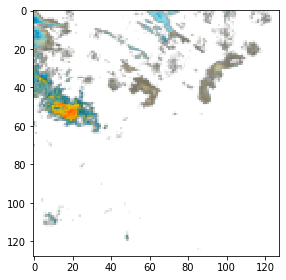

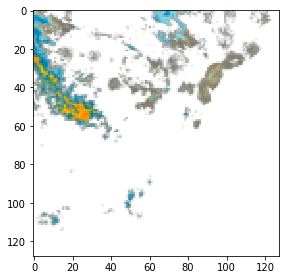

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

### Build Model

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 592         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

### Train Model

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-w251weather-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=64, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

### Predict

In [ ]:
# Predict on train, val and test
model = load_model('model-w251weather-1.h5',  custom_objects={'mean_iou': tf.keras.metrics.MeanIoU(num_classes=2)})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train))
imshow(X_train[ix]) #input image
plt.show()
imshow(np.squeeze(Y_train[ix])) #target output
plt.show()
imshow(np.squeeze(preds_train[ix])) #predicted output
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val[ix]))
plt.show()